In [46]:
import openmc 
import pandas as pd
import openmc.deplete as od
import math
import numpy as np
import matplotlib.pyplot as plt
openmc.config['cross_sections'] = "/home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/cross_sections.xml"

# VOYGR model
The VOYGR modeled is simplified by using a PWR assembly model, specifically the [example model 
in OpenMC](https://docs.openmc.org/en/latest/pythonapi/generated/openmc.examples.pwr_assembly.html#openmc.examples.pwr_assembly).
The Fuel material is modified to be 4.09% weight fraction U-235, in a UO2 form. This modification 
matches the input fuel for the VOYGR used in the transition scenarios.

Thermal spectrum n_bar values are from [IAEA Handbook of Nuclear Data Safeguards, 2008](https://www-nds.iaea.org/sgnucdat/safeg2008.pdf)

In [2]:
pwr_model = openmc.examples.pwr_assembly()

pwr_model.materials[0].nuclides.clear()
pwr_model.materials[0].add_nuclide("U235", 0.0404, 'ao')
pwr_model.materials[0].add_nuclide("U238", 0.9596, 'ao')
pwr_model.materials[0].add_nuclide("O16", 2, 'ao')
fuel = pwr_model.materials[0]

openmc.config['cross_sections'] = "/home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/cross_sections.xml"

In [ ]:
voygr_cross_sections = od.MicroXS.from_model(pwr_model, 
                                       domain = fuel, 
                                       chain_file="./voygr/chain_casl_pwr.xml")

 Reading In113 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/In113.h5
 Reading In115 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/In115.h5
 Reading Sb121 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/Sb121.h5
 Reading Sb123 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/Sb123.h5
 Reading Sb125 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/Sb125.h5
 Reading Te127_m1 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/Te127_m1.h5
 Reading Te129_m1 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/Te129_m1.h5
 Reading Te132 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/Te132.h5
 Reading I127 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/I127.h5
 Reading I128 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/I128.h5
 Reading I129 from
 /home/abachmann@anl.go

 Reading Gd154 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/Gd154.h5
 Reading Gd155 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/Gd155.h5
 Reading Gd156 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/Gd156.h5
 Reading Gd157 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/Gd157.h5
 Reading Gd158 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/Gd158.h5
 Reading Gd159 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/Gd159.h5
 Reading Gd160 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/Gd160.h5
 Reading Tb159 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/Tb159.h5
 Reading Tb160 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/Tb160.h5
 Reading Tb161 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/Tb161.h5
 Reading Dy160 from
 /home/abachmann@anl.gov/openm

In [ ]:
voygr_cross_sections.to_csv("voygr/micro_xs.csv")

In [ ]:
voygr_cross_sections

### Calculate Pu equivalence for MOX recipe

In [ ]:
nu_235 = 2.4355
nu_238 = 2.819
nu_239 = 2.836

In [ ]:
p_235 = nu_235*voygr_cross_sections.loc['U235']['fission'] - voygr_cross_sections.loc['U235']['(n,gamma)']
p_238 = nu_238*voygr_cross_sections.loc['U238']['fission'] - voygr_cross_sections.loc['U238']['(n,gamma)']
p_239 = nu_239*voygr_cross_sections.loc['Pu239']['fission'] - voygr_cross_sections.loc['Pu239']['(n,gamma)']

In [ ]:
equivalence = (p_235-p_238)/(p_239-p_238)

In [ ]:
Pu_enrich = 4.09/equivalence
Pu_enrich # weight fraction of the actinides

# Xe-100 model 

This data is based on the Serpent model of the Sanagmon200. Serpent generated the cross 
section data, which then was converted to the correct form for OpenMC

In [ ]:
file = "./htgr-mr-full-core.inp_mdx0.m"
serpent_data = pd.read_csv(file, skiprows=1, skipfooter=2,delimiter=' ', usecols=[0,3,10], header=None)

In [ ]:
openmc_data = pd.DataFrame(columns=['nuclide','(n,gamma)','(n,2n)','(n,p)','(n,a)','(n,3n)','(n,4n)','fission'])

In [ ]:
for ii in range(0, 3318,6):
    zai = int(serpent_data.iloc[ii][0])
    Z= math.floor(zai/10000)
    A=math.floor((zai-Z*10000)/10)
    m = zai -(Z*10000 +A*10)
    nucname = openmc.data.gnds_name(Z,A,m)
    dictionary = {'nuclide':nucname, '(n,gamma)':serpent_data.iloc[ii][10],
                  '(n,2n)':serpent_data.iloc[ii+1][10],'(n,p)':serpent_data.iloc[ii+2][10],
                  '(n,a)':serpent_data.iloc[ii+3][10],'(n,3n)':serpent_data.iloc[ii+4][10],
                  '(n,4n)':0.0, 'fission':serpent_data.iloc[ii+5][10]}
    openmc_data.loc[len(openmc_data)] = dictionary
# append on last nuclide
openmc_data.loc[len(openmc_data)] = {'nuclide':'Es255', '(n,gamma)':0,
                  '(n,2n)':0,'(n,p)':0,
                  '(n,a)':serpent_data.iloc[ii+3][10],'(n,3n)':0,
                  '(n,4n)':0.0, 'fission':0}
openmc_data = openmc_data.set_index('nuclide')

In [ ]:
openmc_data.to_csv("./xe-100/micro_xs.csv")

In [ ]:
xe100_cross_sections = od.MicroXS.from_csv("./xe-100/micro_xs.csv")

### Calculate Pu equivalence for MOX

In [ ]:
nu_235 = 2.4355
nu_238 = 2.819
nu_239 = 2.836

In [ ]:
p_235 = nu_235*xe100_cross_sections.loc['U235']['fission'] - xe100_cross_sections.loc['U235']['(n,gamma)']
p_238 = nu_238*xe100_cross_sections.loc['U238']['fission'] - xe100_cross_sections.loc['U238']['(n,gamma)']
p_239 = nu_239*xe100_cross_sections.loc['Pu239']['fission'] - xe100_cross_sections.loc['Pu239']['(n,gamma)']

In [ ]:
equivalence = (p_235-p_238)/(p_239-p_238)

In [ ]:
Pu_enrich = 15.5/equivalence
Pu_enrich # weight fraction of the actinides

# Sodium Fast Reactor
SFR Model for use in transition scenarios with a closed fuel cycle. Starting the model from the
[sample SFR model from OpenMC](https://nbviewer.org/github/mit-crpg/openmc-reactor-examples/blob/main/SFR.ipynb),
and adjusted with information from the PRISM reactor as available. 

Sources: 
* Brian S. Triplett, Eric P. Loewen & Brett J. Dooies (2012) PRISM: A Competitive Small Modular Sodium-Cooled Reactor, Nuclear Technology, 178:2, 186-200, DOI: 10.13182/NT178-186
* Other paper to be added
* Dissertation from Sumner

Fast spectrum nu_bar values are from ???

In [2]:
sfr_model = openmc.Model()

In [3]:
# Materials definitions

u235 = openmc.Material(name='U235', material_id=1)
u235.add_nuclide('U235', 1.0)
u235.set_density('g/cm3', 15.05)

u238 = openmc.Material(name='U238', material_id=2)
u238.add_nuclide('U238', 1.0)
u238.set_density('g/cm3', 15.05)

np237 = openmc.Material(name='Np237', material_id=3)
np237.add_nuclide('Np237', 1.0)
np237.set_density('g/cm3', 15.05)

pu238 = openmc.Material(name='Pu238', material_id=4)
pu238.add_nuclide('Pu238', 1.0)
pu238.set_density('g/cm3', 15.05)

pu239 = openmc.Material(name='Pu239', material_id=5)
pu239.add_nuclide('Pu239', 1.0)
pu239.set_density('g/cm3', 15.05)

pu240 = openmc.Material(name='Pu240', material_id=6)
pu240.add_nuclide('Pu240', 1.0)
pu240.set_density('g/cm3', 15.05)

pu241 = openmc.Material(name='Pu241', material_id=7)
pu241.add_nuclide('Pu241', 1.0)
pu241.set_density('g/cm3', 15.05)

pu242 = openmc.Material(name='Pu242', material_id=8)
pu242.add_nuclide('Pu242', 1.0)
pu242.set_density('g/cm3', 15.05)

am241 = openmc.Material(name='Am241', material_id=9)
am241.add_nuclide('Am241', 1.0)
am241.set_density('g/cm3', 15.05)

am243 = openmc.Material(name='Am243', material_id=10)
am243.add_nuclide('Am243', 1.0)
am243.set_density('g/cm3', 15.05)

zr90 = openmc.Material(name='Zr90', material_id=11)
zr90.add_nuclide('Zr90', 1.0)
zr90.set_density('g/cm3', 15.05)

sodium = openmc.Material(name='Na', material_id=12)
sodium.add_nuclide('Na23', 1.0)
sodium.set_density('g/cm3', 0.96)

fe56 = openmc.Material(name='Fe56', material_id=13)
fe56.set_density('g/cm3', 7.73)
fe56.add_nuclide('Fe56', 1.0)

cr52 = openmc.Material(name='Cr52', material_id=14)
cr52.set_density('g/cm3', 7.73)
cr52.add_nuclide('Cr52', 1.0)
                  
mo = openmc.Material(name='Mo', material_id=15)
mo.set_density('g/cm3', 7.73)
mo.add_element('Mo', 1.0)

In [4]:
# Material mixtures
inner = openmc.Material.mix_materials(
    [u235, u238, np237, pu238, pu239, pu240, pu241, pu242, am241, am243, zr90],
    [0.0051, 0.7059, 0.0190, 0.0009, 0.1010, 0.0344, 0.0120, 0.0027, 0.0158, 0.0032, 0.10],
    'wo')
outer = openmc.Material.mix_materials(
    [u235, u238, np237, pu238, pu239, pu240, pu241, pu242, am241, am243, zr90],
    [0.0048, 0.6682, 0.0230, 0.0011, 0.12061, 0.0417, 0.01436, 0.00322, 0.0191, 0.00391, 0.1],
    'wo')
clad = openmc.Material.mix_materials(
    [fe56, cr52, mo], [0.87, 0.12, 0.01], 'wo')
inner.id = 16
outer.id = 17
clad.id = 18
inner.volume = 15.5496 #cm^2, area of pin cell
outer.volume = 15.5496 #15.5496 #cm^3, volume with 66 cm height 
inner.depletable=True
outer.depletable = True
inner.name = 'inner fuel'
outer.name = 'outer fuel'
clad.name = 'cladding'

/home/abachmann@anl.gov/anaconda3/envs/openmcyclus-env/lib/python3.10/site-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=16.
  warn(msg, IDWarning)
/home/abachmann@anl.gov/anaconda3/envs/openmcyclus-env/lib/python3.10/site-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=17.
  warn(msg, IDWarning)
/home/abachmann@anl.gov/anaconda3/envs/openmcyclus-env/lib/python3.10/site-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=18.
  warn(msg, IDWarning)


In [5]:
# Instantiate a Materials collection and export to xml
materials_file = openmc.Materials([inner, outer, sodium, clad])
materials_file.export_to_xml()

In [6]:
# Geometry definitions

fuel_or = openmc.ZCylinder(surface_id=1, r=0.27385) 
clad_ir = openmc.ZCylinder(surface_id=2, r=0.30385) 
clad_or = openmc.ZCylinder(surface_id=3, r=0.35975) 

top = openmc.ZPlane(surface_id=4, z0=+33, boundary_type='vacuum')
bottom = openmc.ZPlane(surface_id=5, z0=-33, boundary_type='vacuum') 

fuel_region = -fuel_or & -top & +bottom
gap_region  = +fuel_or & -clad_ir& -top & +bottom
clad_region = +clad_ir & -clad_or& -top & +bottom
moderator_region = +clad_or& -top & +bottom
 
gap_cell = openmc.Cell(cell_id=1, fill=inner, region=gap_region, name='gap cell')
clad_cell = openmc.Cell(cell_id=2, fill=clad, region=clad_region, name='clad cell')
sodium_cell = openmc.Cell(cell_id=3,fill=sodium, region=moderator_region, name='sodium cell')

In [7]:
inner_fuel_cell = openmc.Cell(cell_id=4, fill=inner, region=fuel_region, name='inner fuel cell')
inner_u = openmc.Universe(universe_id=1, cells=(inner_fuel_cell, gap_cell, clad_cell, sodium_cell), name='inner u')

In [8]:
outer_fuel_cell = openmc.Cell(cell_id=5, fill=outer, region=fuel_region)

# reserve the next 10 cell IDs to avoid an ID 
openmc.reserve_ids(range(6, 35), openmc.Cell)
cloned_cells = [c.clone(clone_materials=False, clone_regions=False) for c in [gap_cell, clad_cell, sodium_cell]]
outer_u = openmc.Universe(universe_id=2, cells=[outer_fuel_cell]+cloned_cells)

In [9]:
# Creating filling for emtpy space in the core
sodium_mod_cell = openmc.Cell(cell_id=6, fill=sodium, name='sodium mod cell')
sodium_mod_u = openmc.Universe(universe_id=3, cells=(sodium_mod_cell,), name='sodium mod u')

/home/abachmann@anl.gov/anaconda3/envs/openmcyclus-env/lib/python3.10/site-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=6.
  warn(msg, IDWarning)


In [10]:
# Define a lattice for inner assemblies
in_lat = openmc.HexLattice(lattice_id=100, name='inner assembly')
in_lat.center = (0., 0.)
in_lat.pitch = [0.8495] #21.08/17 # 16.142
in_lat.orientation = 'x'
in_lat.outer = sodium_mod_u

# Create rings of fuel universes that will fill the lattice
inten = [inner_u]*54
inone = [inner_u]*48 #36
intwo = [inner_u]*42 #28
inthree = [inner_u]*36 #21
infour = [inner_u]*30 #15
infive = [inner_u]*24 #10
insix = [inner_u]*18 #6
inseven = [inner_u]*12 #3
ineight = [inner_u]*6 #1
innine = [inner_u]*1
in_lat.universes = [inten, inone,intwo,inthree,infour,infive,insix,inseven,ineight,innine]

# Create the prism that will contain the lattice
outer_in_surface = openmc.model.hexagonal_prism(edge_length=9.32, orientation='x')

# Fill a cell with the lattice. This cell is filled with the lattice and contained within the prism.
main_in_assembly = openmc.Cell(cell_id=7, fill=in_lat, region=outer_in_surface& -top & +bottom , name='main in assembly')

# Fill a cell with a material that will surround the lattice
out_in_assembly  = openmc.Cell(cell_id=8, fill=sodium, region=~outer_in_surface& -top & +bottom, name='out in assembly')

# Create a universe that contains both 
main_in_u = openmc.Universe(universe_id=4, cells=[main_in_assembly, out_in_assembly], name='main in u')

/home/abachmann@anl.gov/anaconda3/envs/openmcyclus-env/lib/python3.10/site-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=7.
  warn(msg, IDWarning)
/home/abachmann@anl.gov/anaconda3/envs/openmcyclus-env/lib/python3.10/site-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=8.
  warn(msg, IDWarning)


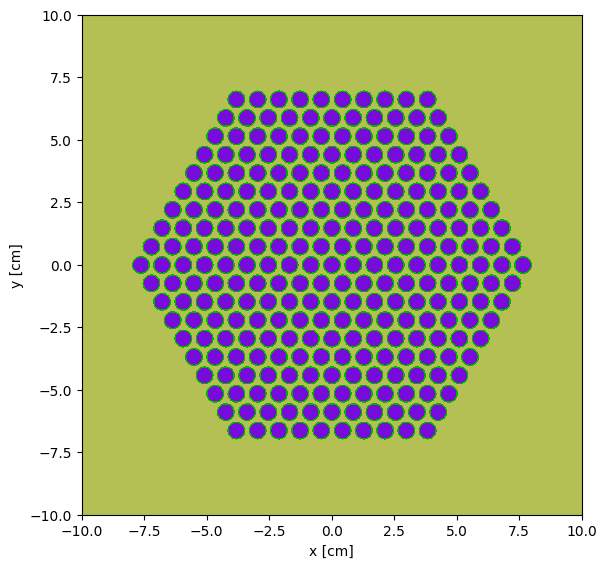

In [11]:
main_in_u.plot(origin = (0,0,0), pixels=(500, 500), width = (20.,20.), color_by = 'material')

In [12]:
# Define a lattice for outer assemblies
out_lat = openmc.HexLattice(lattice_id=200, name='outer assembly')
out_lat.center = (0., 0.)
out_lat.pitch = (0.8495,)
out_lat.orientation = 'x'
out_lat.outer = sodium_mod_u

# Create rings of fuel universes that will fill the lattice
outten = [outer_u]*54
outone = [outer_u]*48
outtwo = [outer_u]*42
outthree = [outer_u]*36
outfour = [outer_u]*30
outfive = [outer_u]*24
outsix = [outer_u]*18
outseven = [outer_u]*12
outeight = [outer_u]*6
outnine = [outer_u]*1
out_lat.universes = [outten, outone,outtwo,outthree,outfour,outfive,outsix,outseven,outeight,outnine]

# Create the prism that will contain the lattice
outer_out_surface = openmc.model.hexagonal_prism(edge_length=9.32, orientation='x')

# Fill a cell with the lattice. This cell is filled with the lattice and contained within the prism.
main_out_assembly = openmc.Cell(cell_id=9, fill=out_lat, region=outer_out_surface& -top & +bottom, name='main out assembly')

# Fill a cell with a material that will surround the lattice
out_out_assembly  = openmc.Cell(cell_id=10, fill=sodium,  region=~outer_out_surface & -top & +bottom, name='out out assembly')

# Create a universe that contains both 
main_out_u = openmc.Universe(universe_id=5, cells=[main_out_assembly, out_out_assembly], name='main out u')

/home/abachmann@anl.gov/anaconda3/envs/openmcyclus-env/lib/python3.10/site-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=9.
  warn(msg, IDWarning)
/home/abachmann@anl.gov/anaconda3/envs/openmcyclus-env/lib/python3.10/site-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=10.
  warn(msg, IDWarning)


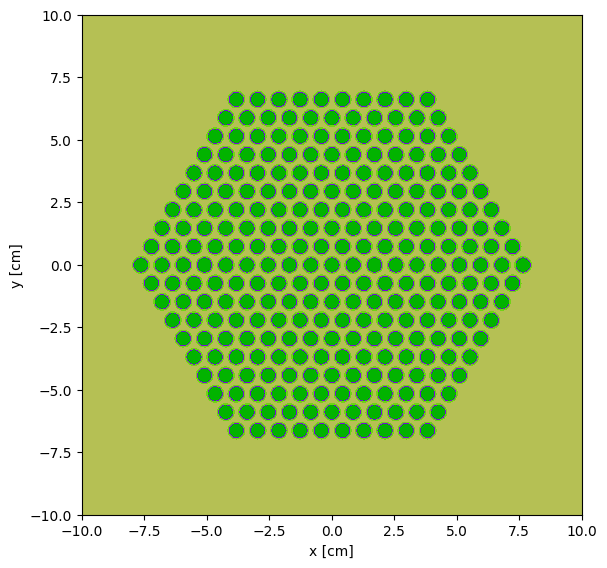

In [13]:
main_out_u.plot(origin = (0,0,0), pixels=(500, 500), width = (20.,20.), color_by = 'material')

In [14]:
# Create a hexagonal water cell -- can use for non-fuel assemblies

reflector_assembly = openmc.model.hexagonal_prism(edge_length=9.32, orientation='x')
ref_cell = openmc.Cell(cell_id=11, fill=sodium, region=reflector_assembly , name='ref cell')
out_ref_cell  = openmc.Cell(cell_id=12, fill=sodium, region=~reflector_assembly , name='out ref cell')
ref_u = openmc.Universe(universe_id=6, cells=[ref_cell, out_ref_cell], name='ref u')

/home/abachmann@anl.gov/anaconda3/envs/openmcyclus-env/lib/python3.10/site-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=11.
  warn(msg, IDWarning)
/home/abachmann@anl.gov/anaconda3/envs/openmcyclus-env/lib/python3.10/site-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=12.
  warn(msg, IDWarning)


In [15]:
core_lat = openmc.HexLattice(lattice_id=300, name='core')
core_lat.center = (0., 0.)
core_lat.pitch = (16.142,)
core_lat.outer = sodium_mod_u

In [16]:
# Create rings of fuel universes that will fill the lattice
ring_one = [ref_u]*66
ring_two = [ref_u]*60
ring_three = [ref_u]*54
ring_four = ([ref_u] + [main_out_u]*7 + [ref_u] + [main_out_u]*7 + 
             [ref_u] + [main_out_u]*7 + [ref_u] + [main_out_u]*7 +
             [ref_u] + [main_out_u]*7 + [ref_u] + [main_out_u]*7)
ring_five = ([ref_u] + [main_out_u]*6 + [ref_u] + [main_out_u]*6 + 
             [ref_u] + [main_out_u]*6 + [ref_u] + [main_out_u]*6 +
             [ref_u] + [main_out_u]*6 + [ref_u] + [main_out_u]*6)
ring_six = ([main_out_u]*3 + [ref_u] + [main_out_u]*5 + [ref_u] + [main_out_u]*5 + 
            [ref_u] + [main_out_u]*5 + [ref_u] + [main_out_u]*5 + [ref_u] + 
            [main_out_u]*5 + [ref_u] + [main_out_u]*2)

ring_seven = [main_in_u]*30
ring_eight = [main_in_u]*24
ring_nine = ([ref_u] + [main_in_u]*2 + [ref_u] + [main_in_u]*2 + [ref_u] + [main_in_u]*2 + 
             [ref_u] + [main_in_u]*2 + [ref_u] + [main_in_u]*2 + [ref_u] + [main_in_u]*2)
ring_ten = [main_in_u]*12
ring_eleven = [main_in_u]*6
ring_twelve = [ref_u]*1
core_lat.universes = [ring_one, ring_two, ring_three, ring_four, ring_five,ring_six, ring_seven, ring_eight, ring_nine, ring_ten, ring_eleven, ring_twelve]

In [17]:
# Create the prism that will contain the lattice
outer_core_surface = openmc.model.hexagonal_prism(edge_length=214.351, boundary_type='vacuum')

# Fill a cell with the lattice. This cell is filled with the lattice and contained within the prism.
core = openmc.Cell(cell_id=13, fill=core_lat, region=outer_core_surface& -top & +bottom, name='core cell')

# Fill a cell with a material that will surround the lattice
out_core = openmc.Cell(cell_id=14, fill=outer, region=~outer_core_surface& -top & +bottom, name='out core')

# Create a universe that contains both 
main_u = openmc.Universe(universe_id=7,cells=[core, out_core], name='main u')


/home/abachmann@anl.gov/anaconda3/envs/openmcyclus-env/lib/python3.10/site-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=13.
  warn(msg, IDWarning)
/home/abachmann@anl.gov/anaconda3/envs/openmcyclus-env/lib/python3.10/site-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=14.
  warn(msg, IDWarning)


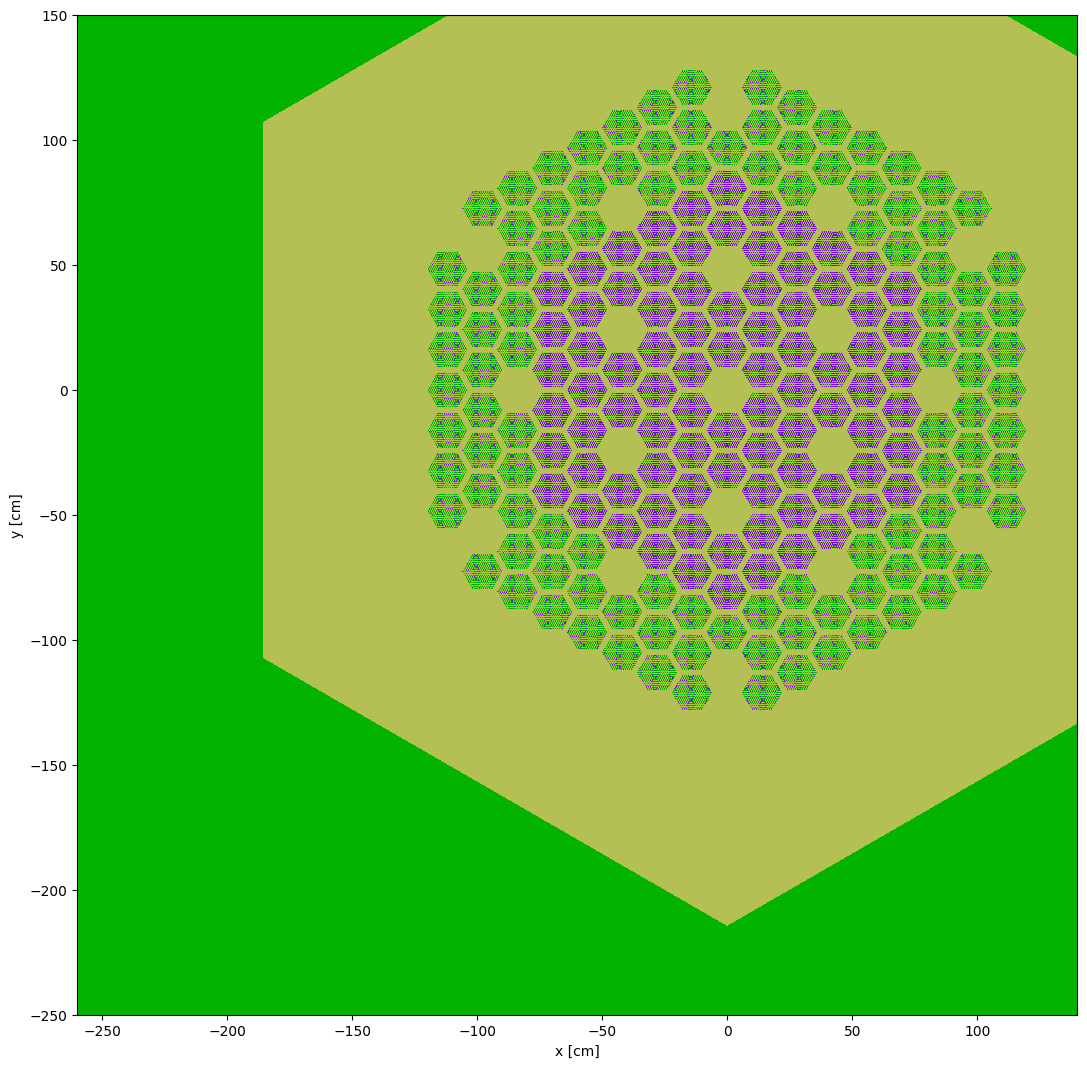

In [18]:
fig = main_u.plot(origin =(-60,-50,0), pixels=(1000, 1000), width = (400.,400.), color_by = 'material')
plt.savefig("sfr_core_lattice_zoom.pdf")

In [19]:
geometry = openmc.Geometry(main_u)
geometry.export_to_xml()

In [20]:
# OpenMC simulation parameters

lower_left = [-300, -300, -50]
upper_right = [300, 300, 50]
uniform_dist = openmc.stats.Box(lower_left, upper_right, only_fissionable=True)
src = openmc.Source(space=uniform_dist)

/home/abachmann@anl.gov/anaconda3/envs/openmcyclus-env/lib/python3.10/site-packages/openmc/source.py:388: FutureWarning: This class is deprecated in favor of 'IndependentSource'
  warnings.warn("This class is deprecated in favor of 'IndependentSource'", FutureWarning)


In [21]:
settings = openmc.Settings()
settings.source = src
settings.batches = 100
settings.inactive = 10
settings.particles = 1000

settings.export_to_xml()

In [22]:
sfr_model.Materials = materials_file
sfr_model.geometry = geometry
sfr_model.settings = settings

In [23]:
# Depleting whole core at BOL (all fresh fuel)
operator = od.CoupledOperator(sfr_model,"./sfr/chain_casl_sfr.xml")
power = 76.65 #311 MWe
time_steps = [1, 2, 5, 10, 12, 15, 15] + [30]*34
integrator = od.PredictorIntegrator(operator, time_steps, power_density = power, timestep_units='d')
integrator.integrate()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

 Reading Ru100 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/Ru100.h5
 Reading Ru101 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/Ru101.h5
 Reading Ru102 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/Ru102.h5
 Reading Ru103 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/Ru103.h5
 Reading Ru104 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/Ru104.h5
 Reading Ru105 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/Ru105.h5
 Reading Ru106 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/Ru106.h5
 Reading Rh103 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/Rh103.h5
 Reading Rh104 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/Rh104.h5
 Reading Rh105 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/Rh105.h5
 Reading Pd104 from
 /home/abachmann@anl.gov/openm

 Reading I135 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/I135.h5
 Reading Xe128 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/Xe128.h5
 Reading Xe130 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/Xe130.h5
 Reading Xe131 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/Xe131.h5
 Reading Xe132 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/Xe132.h5
 Reading Xe133 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/Xe133.h5
 Reading Xe134 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/Xe134.h5
 Reading Xe135 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/Xe135.h5
 Reading Xe136 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/Xe136.h5
 Reading Cs133 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/Cs133.h5


          2500K
          1200K
          2500K


 Reading Cs134 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/Cs134.h5
 Reading Cs135 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/Cs135.h5
 Reading Cs136 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/Cs136.h5
 Reading Cs137 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/Cs137.h5
 Reading Ba134 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/Ba134.h5
 Reading Ba137 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/Ba137.h5
 Reading Ba140 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/Ba140.h5
 Reading La139 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/La139.h5
 Reading La140 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/La140.h5
 Reading Ce140 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/Ce140.h5
 Reading Ce141 from
 /home/abachmann@anl.gov/openm

          1200K
          2500K


 Reading Gd154 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/Gd154.h5
 Reading Gd155 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/Gd155.h5
 Reading Gd156 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/Gd156.h5
 Reading Gd157 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/Gd157.h5
 Reading Gd158 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/Gd158.h5
 Reading Gd159 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/Gd159.h5
 Reading Gd160 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/Gd160.h5
 Reading Tb159 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/Tb159.h5
 Reading Tb160 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/Tb160.h5
 Reading Tb161 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/Tb161.h5
 Reading Dy160 from
 /home/abachmann@anl.gov/openm

          1200K
          2500K


 Reading Ta182 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/Ta182.h5
 Reading Th230 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/Th230.h5
 Reading Th231 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/Th231.h5
 Reading Th232 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/Th232.h5
 Reading Th233 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/Th233.h5
 Reading Th234 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/Th234.h5
 Reading Pa231 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/Pa231.h5
 Reading Pa232 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/Pa232.h5
 Reading Pa233 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/Pa233.h5
 Reading U232 from
 /home/abachmann@anl.gov/openmc-xs-data/endfb-viii.0-hdf5/neutron/U232.h5
 Reading U233 from
 /home/abachmann@anl.gov/openmc-x

In [23]:
# Getting compositions
results = od.Results("./depletion_results.h5")

In [24]:
t, k = results.get_keff(time_units='d')

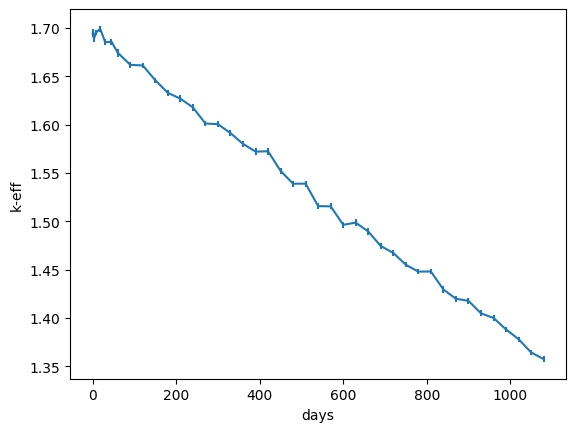

In [25]:
import matplotlib.pyplot as plt
plt.errorbar(t, k[:,0], yerr=k[:,1])
plt.xlabel('days')
plt.ylabel('k-eff')
plt.savefig('sfr-keff.png')

In [26]:
ignore_list = ['Br82', 'Tc99_m1', 'Tc100', 'Rh102', 'Rh102_m1', 'Rh103_m1',
              'Rh105_m1','Rh106', 'Sb127', 'Te127'] # nuclides not found in the cross section library
inner_1 = openmc.Material(name = 'batch 1 inner', material_id=19)
for nuclide in results[17].get_material('16').nuclides:
    if nuclide.percent <= 1e-8:
        continue
    if nuclide.name in ignore_list:
        continue
    inner_1.add_nuclide(str(nuclide.name), nuclide.percent)
inner_1.set_density('g/cm3',15.05)
inner_1.volume = 15.5496 #cm^3 
inner_1.depletable=True

inner_2 = openmc.Material(name = 'batch 2 inner', material_id=20)
for nuclide in results[29].get_material('16').nuclides:
    if nuclide.percent <= 1e-8:
        continue
    if nuclide.name in ignore_list:
        continue
    inner_2.add_nuclide(str(nuclide.name), nuclide.percent)
inner_2.set_density('g/cm3',15.05)
inner_2.volume = 15.5496 #cm^3
inner_2.depletable=True


inner_3 = openmc.Material(name = 'batch 3 inner', material_id=21)
for nuclide in results[-1].get_material('16').nuclides:
    if nuclide.percent <= 1e-8:
        continue
    if nuclide.name in ignore_list:
        continue
    inner_3.add_nuclide(str(nuclide.name), nuclide.percent)
inner_3.set_density('g/cm3',15.05)
inner_3.volume = 15.5496 #cm^3
inner_3.depletable=True

In [27]:
#Define inner fuel cells and universes for eahc batch
inner_1_cell = openmc.Cell(cell_id=15, fill=inner_1, region=fuel_region, name='inner 1 cell')
cloned_cells = [c.clone(clone_materials=False, clone_regions=False) for c in [gap_cell, clad_cell, sodium_cell]]
inner_1_u = openmc.Universe(universe_id=8, cells=[inner_1_cell] + cloned_cells, name='inner 1')
inner_2_cell = openmc.Cell(cell_id=16, fill=inner_2, region=fuel_region, name='inner 2 cell')
cloned_cells = [c.clone(clone_materials=False, clone_regions=False) for c in [gap_cell, clad_cell, sodium_cell]]
inner_2_u = openmc.Universe(universe_id=9, cells=[inner_2_cell] + cloned_cells, name='inner 2')
inner_3_cell = openmc.Cell(cell_id=17, fill=inner_3, region=fuel_region, name='inner 3 cell')
cloned_cells = [c.clone(clone_materials=False, clone_regions=False) for c in [gap_cell, clad_cell, sodium_cell]]
inner_3_u = openmc.Universe(universe_id=10, cells=[inner_3_cell] + cloned_cells, name='inner 3')

/home/abachmann@anl.gov/anaconda3/envs/openmcyclus-env/lib/python3.10/site-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=15.
  warn(msg, IDWarning)
/home/abachmann@anl.gov/anaconda3/envs/openmcyclus-env/lib/python3.10/site-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=16.
  warn(msg, IDWarning)
/home/abachmann@anl.gov/anaconda3/envs/openmcyclus-env/lib/python3.10/site-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=17.
  warn(msg, IDWarning)


In [28]:
outer_1 = openmc.Material(name = 'batch 1 outer', material_id=22)
for nuclide in results[17].get_material('17').nuclides:
    if nuclide.percent <= 1e-8:
        continue
    if nuclide.name in ignore_list:
        continue
    outer_1.add_nuclide(str(nuclide.name), nuclide.percent)
outer_1.set_density('g/cm3',15.05)
outer_1.volume = 15.5496 #cm^3
outer_1.depletable=True

outer_2 = openmc.Material(name = 'batch 2 outer', material_id=23)
for nuclide in results[29].get_material('17').nuclides:
    if nuclide.percent <= 1e-8:
        continue
    if nuclide.name in ignore_list:
        continue
    outer_2.add_nuclide(str(nuclide.name), nuclide.percent)
outer_2.set_density('g/cm3',15.05)
outer_2.volume = 15.5496 #cm^3
outer_2.depletable=True


outer_3 = openmc.Material(name = 'batch 3 outer', material_id=24)
for nuclide in results[-1].get_material('17').nuclides:
    if nuclide.percent <= 1e-8:
        continue
    if nuclide.name in ignore_list:
        continue
    outer_3.add_nuclide(str(nuclide.name), nuclide.percent)
outer_3.set_density('g/cm3',15.05)
outer_3.volume = 15.5496 #cm^3
outer_3.depletable=True

In [29]:
#Define outer fuel cells and universes for each batch
outer_1_cell = openmc.Cell(cell_id=18, fill=outer_1, region=fuel_region, name='outer 1 cell')
cloned_cells = [c.clone(clone_materials=False, clone_regions=False) for c in [gap_cell, clad_cell, sodium_cell]]
outer_1_u = openmc.Universe(universe_id=11, cells=[outer_1_cell] + cloned_cells, name='outer 1')
outer_2_cell = openmc.Cell(cell_id=19, fill=outer_2, region=fuel_region, name='outer 2 cell')
cloned_cells = [c.clone(clone_materials=False, clone_regions=False) for c in [gap_cell, clad_cell, sodium_cell]]
outer_2_u = openmc.Universe(universe_id=12, cells=[outer_2_cell] + cloned_cells, name='outer 2')
outer_3_cell = openmc.Cell(cell_id=20, fill=outer_3, region=fuel_region, name='outer 3 cell')
cloned_cells = [c.clone(clone_materials=False, clone_regions=False) for c in [gap_cell, clad_cell, sodium_cell]]
outer_3_u = openmc.Universe(universe_id=13, cells=[outer_3_cell] + cloned_cells, name='outer 3')

/home/abachmann@anl.gov/anaconda3/envs/openmcyclus-env/lib/python3.10/site-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=18.
  warn(msg, IDWarning)
/home/abachmann@anl.gov/anaconda3/envs/openmcyclus-env/lib/python3.10/site-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=19.
  warn(msg, IDWarning)
/home/abachmann@anl.gov/anaconda3/envs/openmcyclus-env/lib/python3.10/site-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=20.
  warn(msg, IDWarning)


In [30]:
# Define a lattice for inner assemblies for each batch
in_lat_1 = openmc.HexLattice(lattice_id=101, name='inner 1 assembly')
in_lat_1.center = (0., 0.)
in_lat_1.pitch = [0.8495] #21.08/17 # 16.142
in_lat_1.orientation = 'x'
in_lat_1.outer = sodium_mod_u

In [31]:
# Create rings of fuel universes that will fill the lattice
inten_1 = [inner_1_u]*54
inone_1 = [inner_1_u]*48 #36
intwo_1 = [inner_1_u]*42 #28
inthree_1 = [inner_1_u]*36 #21
infour_1 = [inner_1_u]*30 #15
infive_1 = [inner_1_u]*24 #10
insix_1 = [inner_1_u]*18 #6
inseven_1 = [inner_1_u]*12 #3
ineight_1 = [inner_1_u]*6 #1
innine_1 = [inner_1_u]*1
in_lat_1.universes = [inten_1, inone_1,intwo_1,inthree_1,infour_1,infive_1,insix_1,inseven_1,ineight_1,innine_1]

# Create the prism that will contain the lattice
outer_in_surface_1 = openmc.model.hexagonal_prism(edge_length=9.32, orientation='x')

# Fill a cell with the lattice. This cell is filled with the lattice and contained within the prism.
main_in_assembly_1 = openmc.Cell(cell_id=21, fill=in_lat_1, region=outer_in_surface_1, name='main in1 assembly')

# Fill a cell with a material that will surround the lattice
out_in_assembly_1  = openmc.Cell(cell_id=22, fill=sodium, region=~outer_in_surface_1, name='out in1 assembly')

# Create a universe that contains both 
main_in_1_u = openmc.Universe(universe_id=14, cells=[main_in_assembly_1, out_in_assembly_1], name='main in1 u')

in_lat_2 = openmc.HexLattice(lattice_id=102, name='inner 2 assembly')
in_lat_2.center = (0., 0.)
in_lat_2.pitch = [0.8495] #21.08/17 # 16.142
in_lat_2.orientation = 'x'
in_lat_2.outer = sodium_mod_u

# Create rings of fuel universes that will fill the lattice
inten_2 = [inner_2_u]*54
inone_2 = [inner_2_u]*48 #36
intwo_2 = [inner_2_u]*42 #28
inthree_2 = [inner_2_u]*36 #21
infour_2 = [inner_2_u]*30 #15
infive_2 = [inner_2_u]*24 #10
insix_2 = [inner_2_u]*18 #6
inseven_2 = [inner_2_u]*12 #3
ineight_2 = [inner_2_u]*6 #1
innine_2 = [inner_2_u]*1
in_lat_2.universes = [inten_2,inone_2,intwo_2,inthree_2,infour_2,infive_2,insix_2,inseven_2,ineight_2,innine_2]

# Create the prism that will contain the lattice
outer_in_surface_2 = openmc.model.hexagonal_prism(edge_length=9.32, orientation='x')

# Fill a cell with the lattice. This cell is filled with the lattice and contained within the prism.
main_in_assembly_2 = openmc.Cell(cell_id=23, fill=in_lat_2, region=outer_in_surface_2, name='main in2 assembly')

# Fill a cell with a material that will surround the lattice
out_in_assembly_2  = openmc.Cell(cell_id=24, fill=sodium, region=~outer_in_surface_2, name='out in2 assembly')

# Create a universe that contains both 
main_in_2_u = openmc.Universe(universe_id=15, cells=[main_in_assembly_2, out_in_assembly_2], name='main in2 u')

in_lat_3 = openmc.HexLattice(lattice_id=103, name='inner 3 assembly')
in_lat_3.center = (0., 0.)
in_lat_3.pitch = [0.8495] #21.08/17 # 16.142
in_lat_3.orientation = 'x'
in_lat_3.outer = sodium_mod_u

# Create rings of fuel universes that will fill the lattice
inten_3 = [inner_3_u]*54
inone_3 = [inner_3_u]*48 #36
intwo_3 = [inner_3_u]*42 #28
inthree_3 = [inner_3_u]*36 #21
infour_3 = [inner_3_u]*30 #15
infive_3 = [inner_3_u]*24 #10
insix_3 = [inner_3_u]*18 #6
inseven_3 = [inner_3_u]*12 #3
ineight_3 = [inner_3_u]*6 #1
innine_3 = [inner_3_u]*1
in_lat_3.universes = [inten_3,inone_3,intwo_3,inthree_3,infour_3,infive_3,insix_3,inseven_3,ineight_3,innine_3]

# Create the prism that will contain the lattice
outer_in_surface_3 = openmc.model.hexagonal_prism(edge_length=9.32, orientation='x')

# Fill a cell with the lattice. This cell is filled with the lattice and contained within the prism.
main_in_assembly_3 = openmc.Cell(cell_id=25, fill=in_lat_3, region=outer_in_surface_3, name='main in3 assembly')

# Fill a cell with a material that will surround the lattice
out_in_assembly_3  = openmc.Cell(cell_id=26, fill=sodium, region=~outer_in_surface_3, name='out in3 assembly')

# Create a universe that contains both 
main_in_3_u = openmc.Universe(universe_id=16, cells=[main_in_assembly_3, out_in_assembly_3], name='main in3 u')

/home/abachmann@anl.gov/anaconda3/envs/openmcyclus-env/lib/python3.10/site-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=21.
  warn(msg, IDWarning)
/home/abachmann@anl.gov/anaconda3/envs/openmcyclus-env/lib/python3.10/site-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=22.
  warn(msg, IDWarning)
/home/abachmann@anl.gov/anaconda3/envs/openmcyclus-env/lib/python3.10/site-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=23.
  warn(msg, IDWarning)
/home/abachmann@anl.gov/anaconda3/envs/openmcyclus-env/lib/python3.10/site-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=24.
  warn(msg, IDWarning)
/home/abachmann@anl.gov/anaconda3/envs/openmcyclus-env/lib/python3.10/site-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=25.
  warn(msg, IDWarning)
/home/abachmann@anl.gov/anaconda3/envs/openmcyclus-env/lib/python

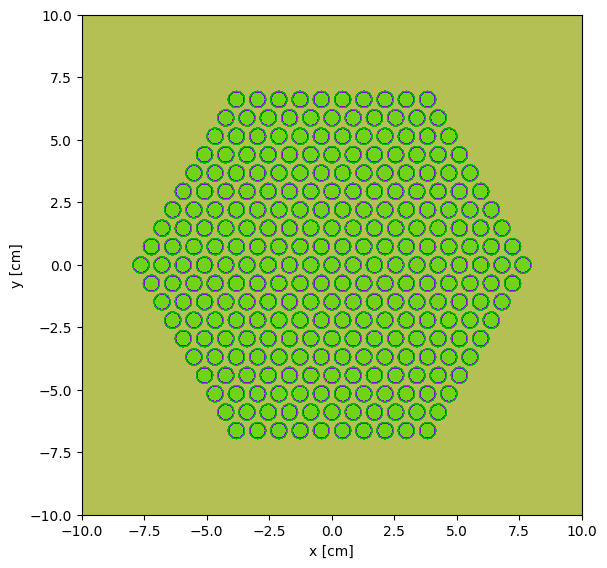

In [32]:
main_in_2_u.plot(origin = (0,0,0), pixels=(500, 500), width = (20.,20.), color_by = 'material')

In [33]:
# Define a lattice for outer assemblies for each batch
out_lat_1 = openmc.HexLattice(lattice_id=201, name='outer 1 assembly')
out_lat_1.center = (0., 0.)
out_lat_1.pitch = [0.8495] #21.08/17 # 16.142
out_lat_1.orientation = 'x'
out_lat_1.outer = sodium_mod_u

# Create rings of fuel universes that will fill the lattice
outten_1 = [outer_1_u]*54
outone_1 = [outer_1_u]*48 #36
outtwo_1 = [outer_1_u]*42 #28
outthree_1 = [outer_1_u]*36 #21
outfour_1 = [outer_1_u]*30 #15
outfive_1 = [outer_1_u]*24 #10
outsix_1 = [outer_1_u]*18 #6
outseven_1 = [outer_1_u]*12 #3
outeight_1 = [outer_1_u]*6 #1
outnine_1 = [outer_1_u]*1
out_lat_1.universes = [outten_1, outone_1,outtwo_1,outthree_1,outfour_1,outfive_1,outsix_1,outseven_1,outeight_1,outnine_1]

# Create the prism that will contain the lattice
outer_out_surface_1 = openmc.model.hexagonal_prism(edge_length=9.32, orientation='x')

# Fill a cell with the lattice. This cell is filled with the lattice and contained within the prism.
main_out_assembly_1 = openmc.Cell(cell_id=27, fill=out_lat_1, region=outer_in_surface, name='main out1 assembly')

# Fill a cell with a material that will surround the lattice
out_out_assembly_1  = openmc.Cell(cell_id=28, fill=sodium, region=~outer_in_surface, name='out out1 assembly')

# Create a universe that contains both 
main_out_1_u = openmc.Universe(universe_id=17, cells=[main_out_assembly_1, out_out_assembly_1], name='main out1 u')

out_lat_2 = openmc.HexLattice(lattice_id=202, name='outer 2 assembly')
out_lat_2.center = (0., 0.)
out_lat_2.pitch = [0.8495] #21.08/17 # 16.142
out_lat_2.orientation = 'x'
out_lat_2.outer = sodium_mod_u

# Create rings of fuel universes that will fill the lattice
outten_2 = [outer_2_u]*54
outone_2 = [outer_2_u]*48 #36
outtwo_2 = [outer_2_u]*42 #28
outthree_2 = [outer_2_u]*36 #21
outfour_2 = [outer_2_u]*30 #15
outfive_2 = [outer_2_u]*24 #10
outsix_2 = [outer_2_u]*18 #6
outseven_2 = [outer_2_u]*12 #3
outeight_2 = [outer_2_u]*6 #1
outnine_2 = [outer_2_u]*1
out_lat_2.universes = [outten_2,outone_2,outtwo_2,outthree_2,outfour_2,outfive_2,outsix_2,outseven_2,outeight_2,outnine_2]

# Create the prism that will contain the lattice
outer_out_surface_2 = openmc.model.hexagonal_prism(edge_length=9.32, orientation='x')

# Fill a cell with the lattice. This cell is filled with the lattice and contained within the prism.
main_out_assembly_2 = openmc.Cell(cell_id=29, fill=out_lat_2, region=outer_out_surface_2, name='main out2 assembly')

# Fill a cell with a material that will surround the lattice
out_out_assembly_2  = openmc.Cell(cell_id=30, fill=sodium, region=~outer_out_surface_2, name='out out2 assembly')

# Create a universe that contains both 
main_out_2_u = openmc.Universe(universe_id=18, cells=[main_out_assembly_2, out_out_assembly_2], name='main out2 u')

out_lat_3 = openmc.HexLattice(lattice_id=203, name='outer 3 assembly')
out_lat_3.center = (0., 0.)
out_lat_3.pitch = [0.8495] #21.08/17 # 16.142
out_lat_3.orientation = 'x'
out_lat_3.outer = sodium_mod_u

# Create rings of fuel universes that will fill the lattice
outten_3 = [outer_3_u]*54
outone_3 = [outer_3_u]*48 #36
outtwo_3 = [outer_3_u]*42 #28
outthree_3 = [outer_3_u]*36 #21
outfour_3 = [outer_3_u]*30 #15
outfive_3 = [outer_3_u]*24 #10
outsix_3 = [outer_3_u]*18 #6
outseven_3 = [outer_3_u]*12 #3
outeight_3 = [outer_3_u]*6 #1
outnine_3 = [outer_3_u]*1
out_lat_3.universes = [outten_3,outone_3,outtwo_3,outthree_3,outfour_3,outfive_3,outsix_3,outseven_3,outeight_3,outnine_3]

# Create the prism that will contain the lattice
outer_out_surface_3 = openmc.model.hexagonal_prism(edge_length=9.32, orientation='x')

# Fill a cell with the lattice. This cell is filled with the lattice and contained within the prism.
main_out_assembly_3 = openmc.Cell(cell_id=31, fill=out_lat_3, region=outer_out_surface_3, name='main out3 assembly')

# Fill a cell with a material that will surround the lattice
out_out_assembly_3  = openmc.Cell(cell_id=32, fill=sodium, region=~outer_out_surface_3, name='out out3 assembly')

# Create a universe that contains both 
main_out_3_u = openmc.Universe(universe_id=19, cells=[main_out_assembly_3, out_out_assembly_3], name='main out3 u')

/home/abachmann@anl.gov/anaconda3/envs/openmcyclus-env/lib/python3.10/site-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=27.
  warn(msg, IDWarning)
/home/abachmann@anl.gov/anaconda3/envs/openmcyclus-env/lib/python3.10/site-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=28.
  warn(msg, IDWarning)
/home/abachmann@anl.gov/anaconda3/envs/openmcyclus-env/lib/python3.10/site-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=29.
  warn(msg, IDWarning)
/home/abachmann@anl.gov/anaconda3/envs/openmcyclus-env/lib/python3.10/site-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=30.
  warn(msg, IDWarning)
/home/abachmann@anl.gov/anaconda3/envs/openmcyclus-env/lib/python3.10/site-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=31.
  warn(msg, IDWarning)
/home/abachmann@anl.gov/anaconda3/envs/openmcyclus-env/lib/python

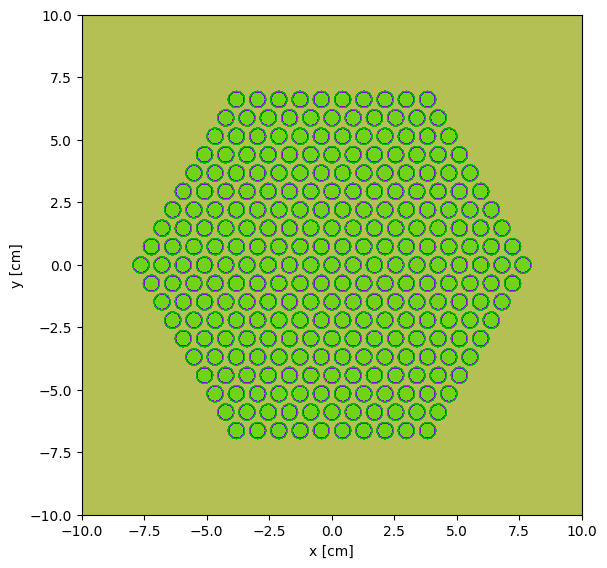

In [34]:
main_out_1_u.plot(pixels=(500, 500),width=(20,20), color_by='material')

In [35]:
eq_core_lat = openmc.HexLattice(lattice_id=400, name='core')
eq_core_lat.center = (0., 0.)
eq_core_lat.pitch = (16.142,)
eq_core_lat.outer = sodium_mod_u

In [36]:
# Create rings of fuel universes that will fill the lattice
ring_one = [ref_u]*66
ring_two = [ref_u]*60
ring_three = [ref_u]*54
ring_four = [ref_u, main_out_3_u, main_out_1_u, main_out_u, main_out_2_u, main_out_u, main_out_3_u, main_out_2_u,
             ref_u, main_out_1_u, main_out_2_u, main_out_3_u, main_out_u, main_out_u, main_out_3_u, main_out_1_u,
             ref_u, main_out_3_u, main_out_2_u, main_out_1_u, main_out_u, main_out_2_u, main_out_3_u, main_out_1_u,
             ref_u, main_out_2_u, main_out_1_u, main_out_3_u, main_out_2_u, main_out_3_u, main_out_1_u, main_out_u,
             ref_u, main_out_3_u, main_out_1_u, main_out_2_u, main_out_u, main_out_1_u, main_out_u, main_out_3_u,
             ref_u, main_out_2_u, main_out_u, main_out_3_u, main_out_1_u, main_out_u, main_out_3_u, main_out_1_u]
ring_five = [ref_u, main_out_u, main_out_2_u, main_out_3_u, main_out_1_u, main_out_2_u, main_out_1_u,
             ref_u, main_out_u, main_out_1_u, main_out_1_u, main_out_3_u, main_out_1_u, main_out_2_u,
             ref_u, main_out_u, main_out_u, main_out_2_u, main_out_1_u, main_out_u, main_out_1_u,
             ref_u, main_out_u, main_out_2_u, main_out_1_u, main_out_u, main_out_2_u,main_out_3_u,
             ref_u, main_out_2_u, main_out_3_u, main_out_1_u, main_out_2_u, main_out_3_u, main_out_2_u,
             ref_u, main_out_3_u, main_out_1_u, main_out_2_u, main_out_u, main_out_1_u, main_out_2_u]
ring_six = [main_out_3_u, main_out_1_u, main_out_u, ref_u, main_out_3_u, main_out_u,
            main_out_3_u, main_out_2_u, main_out_3_u, ref_u, main_out_2_u, main_out_u,
            main_out_3_u, main_out_2_u, main_out_3_u, ref_u, main_out_3_u, main_out_2_u,
            main_out_3_u, main_out_1_u, main_out_u, ref_u, main_out_3_u, main_out_1_u,
            main_out_u, main_out_u, main_out_2_u, ref_u, main_out_1_u, main_out_u,
            main_out_1_u, main_out_2_u, main_out_u, ref_u, main_out_2_u, main_out_u]
ring_seven = [main_in_3_u, main_in_2_u, main_in_1_u, main_in_u, main_in_3_u,
              main_in_u, main_in_3_u, main_in_2_u, main_in_3_u, main_in_u,
              main_in_3_u, main_in_u, main_in_3_u, main_in_2_u, main_in_3_u,
              main_in_u, main_in_3_u, main_in_u, main_in_1_u, main_in_u, 
              main_in_1_u, main_in_3_u, main_in_2_u, main_in_u, main_in_3_u, 
              main_in_u, main_in_3_u, main_in_u, main_in_1_u, main_in_2_u]
ring_eight = [main_in_1_u, main_in_3_u, main_in_2_u, main_in_1_u, main_in_2_u,
              main_in_u, main_in_u, main_in_1_u, main_in_2_u, main_in_1_u,
              main_in_2_u, main_in_1_u, main_in_2_u, main_in_1_u, main_in_u,
              main_in_3_u, main_in_2_u, main_in_u, main_in_3_u, main_in_2_u,
              main_in_1_u, main_in_2_u, main_in_3_u, main_in_u]
ring_nine = ([ref_u, main_in_1_u, main_in_3_u, ref_u, main_in_1_u, main_in_2_u,
              ref_u, main_in_2_u, main_in_u, ref_u, main_in_3_u, main_in_1_u,
              ref_u, main_in_2_u, main_in_1_u, ref_u, main_in_1_u, main_in_2_u])
ring_ten = [main_in_3_u, main_in_u, main_in_2_u, main_in_3_u, main_in_1_u, main_in_3_u,
            main_in_1_u, main_in_u, main_in_1_u, main_in_u, main_in_2_u, main_in_u]
ring_eleven = [main_in_2_u, main_in_1_u, main_in_u, main_in_2_u, main_in_1_u, main_in_3_u]
ring_twelve = [ref_u]*1
eq_core_lat.universes = [ring_one, ring_two, ring_three, ring_four, ring_five,
                     ring_six, ring_seven, ring_eight, ring_nine, 
                     ring_ten, ring_eleven, ring_twelve]



In [37]:
# Create the prism that will contain the lattice
outer_eq_core_surface = openmc.model.hexagonal_prism(edge_length=200, boundary_type='vacuum')

# Fill a cell with the lattice. This cell is filled with the lattice and contained within the prism.
eq_core = openmc.Cell(cell_id=33, fill=eq_core_lat, region=outer_eq_core_surface & -top & +bottom)

# Fill a cell with a material that will surround the lattice
out_eq_core = openmc.Cell(cell_id=34, fill=outer, region=~outer_eq_core_surface & -top & +bottom)

# Create a universe that contains both 
main_eq_u = openmc.Universe(universe_id=20, cells=[eq_core, out_eq_core])
geometry = openmc.Geometry(main_eq_u)
geometry.export_to_xml()



/home/abachmann@anl.gov/anaconda3/envs/openmcyclus-env/lib/python3.10/site-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=33.
  warn(msg, IDWarning)
/home/abachmann@anl.gov/anaconda3/envs/openmcyclus-env/lib/python3.10/site-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=34.
  warn(msg, IDWarning)


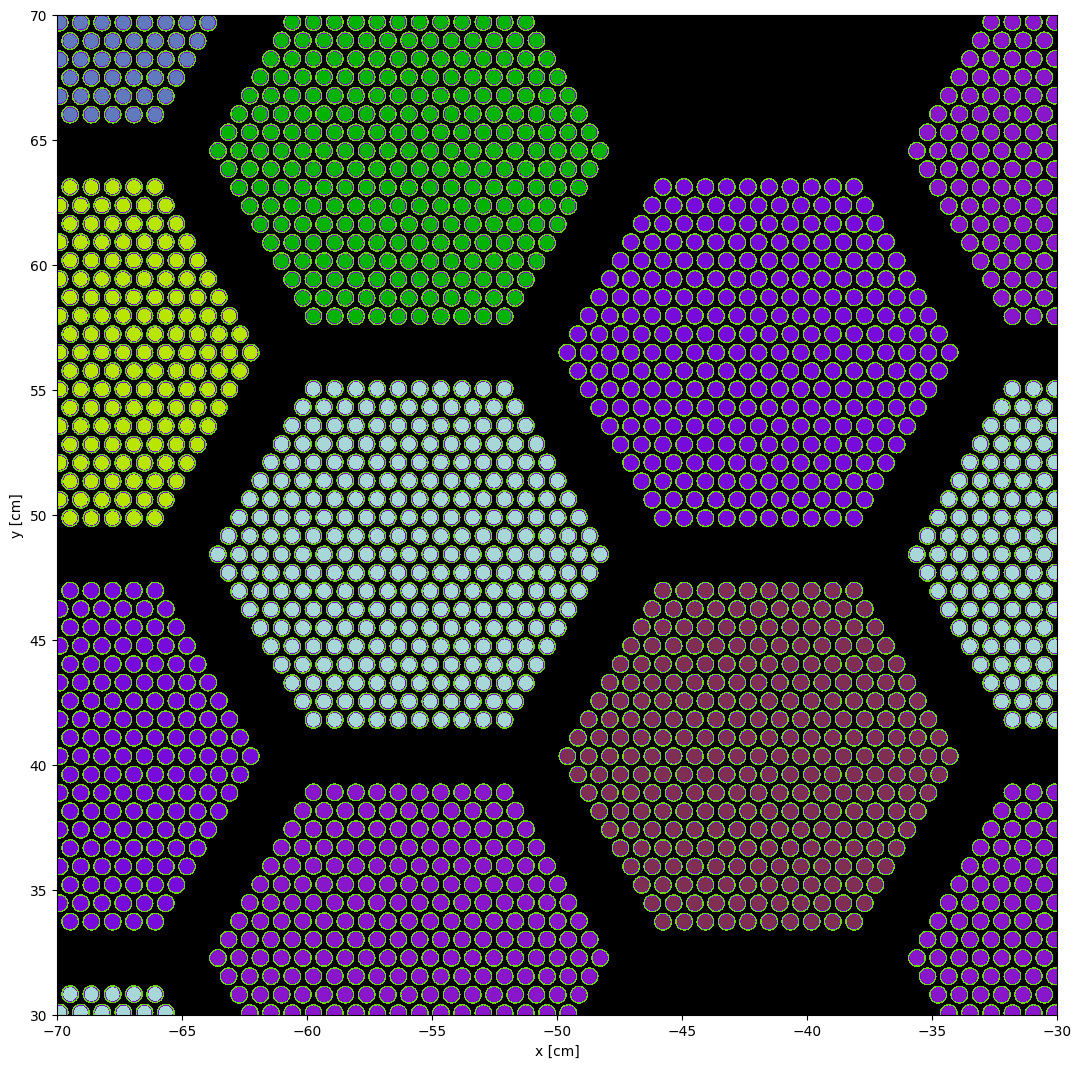

In [100]:
main_eq_u.plot(origin =(-50,50,0), pixels=(1000, 1000), width = (40.,40.), color_by = 'material', 
               colors={sodium:(0,0,0)})
plt.savefig('srf_eq_core_zoom.pdf')

In [39]:
eq_geometry = openmc.Geometry(main_eq_u)
eq_geometry.export_to_xml()

eq_materials_file = openmc.Materials([inner, inner_1, inner_2, inner_3,
                                      outer, outer_1, outer_2, outer_3,
                                      sodium, clad])
eq_materials_file.export_to_xml()

sfr_model.Materials = eq_materials_file
sfr_model.geometry = eq_geometry
sfr_model.settings = settings

In [41]:
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [40]:
sfr_cross_sections = od.MicroXS.from_model(sfr_model, 
                                       domain = main_eq_u, 
                                       chain_file="./sfr/chain_casl_sfr.xml")

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [42]:
sfr_cross_sections.to_csv("sfr/micro_xs.csv")

In [76]:
# Determine fresh fuel recipe for Cyclus by doing a weighted 
# average of the inner and outer fresh fuel compositions
nuclides = [92235, 92238, 93237, 94238, 94239, 94240, 94241, 94242, 95241, 95243, 40090]
inner_comp = np.array([0.0051, 0.7059, 0.0190, 0.0009, 0.1010, 0.0344, 0.0120, 0.0027, 0.0158, 0.0032, 0.10])
outer_comp = np.array([0.0048, 0.6682, 0.0230, 0.0011, 0.12061, 0.0417, 0.01436, 0.00322, 0.0191, 0.00391, 0.1])

averaged_comp = (inner_comp*(84/192)+outer_comp*(108/192))
for index, nuclide in enumerate(nuclides):
    print(f"<nuclide>  <id>{str(nuclide)}</id> <comp>{averaged_comp[index]}</comp>  </nuclide>")

<nuclide>  <id>92235</id> <comp>0.00493125</comp>  </nuclide>
<nuclide>  <id>92238</id> <comp>0.68469375</comp>  </nuclide>
<nuclide>  <id>93237</id> <comp>0.021249999999999998</comp>  </nuclide>
<nuclide>  <id>94238</id> <comp>0.0010125</comp>  </nuclide>
<nuclide>  <id>94239</id> <comp>0.11203062500000001</comp>  </nuclide>
<nuclide>  <id>94240</id> <comp>0.038506250000000006</comp>  </nuclide>
<nuclide>  <id>94241</id> <comp>0.013327499999999999</comp>  </nuclide>
<nuclide>  <id>94242</id> <comp>0.0029925000000000004</comp>  </nuclide>
<nuclide>  <id>95241</id> <comp>0.01765625</comp>  </nuclide>
<nuclide>  <id>95243</id> <comp>0.003599375</comp>  </nuclide>
<nuclide>  <id>40090</id> <comp>0.1</comp>  </nuclide>


### Calculate Pu equivalence to determine HALEU composition

In [80]:
nu_235 = 2.4355
nu_238 = 2.819
nu_239 = 2.836
nu_241 = 2.9479

In [81]:
p_235 = nu_235*sfr_cross_sections.loc['U235']['fission'] - sfr_cross_sections.loc['U235']['(n,gamma)']
p_238 = nu_238*sfr_cross_sections.loc['U238']['fission'] - sfr_cross_sections.loc['U238']['(n,gamma)']
p_239 = nu_239*sfr_cross_sections.loc['Pu239']['fission'] - sfr_cross_sections.loc['Pu239']['(n,gamma)']
p_241 = nu_241*sfr_cross_sections.loc['Pu241']['fission'] - sfr_cross_sections.loc['Pu241']['(n,gamma)']

In [82]:
#239 equivalence
eq_239 = (p_235-p_238)/(p_239-p_238)
enrich_239 = 70/eq_239

In [83]:
#241 equivalence
eq_241 = (p_235-p_238)/(p_241-p_238)
enrich_241 = 8.31/eq_241

In [85]:
enrich_239 #+ enrich_241

102.44835291592221